In [1]:
import os
import time
import math
import glob
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch

DEVICE = "cuda:0"
SAVE_PATH = 'model/fcdensenet_ba_dsm_0.pt'

# set device
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [2]:
## Creating the dataset

In [3]:
classes = ['Void', 'Grass', 'Decidous', 'Conifers', 'Background']
class_weight = torch.FloatTensor([77.2089729 ,  8.61827954,  2.51466749,  2.29694347, 26.32435424])

class ForestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        self.dsm = self.dset['x_dsm']
        #self.dtm = self.dset['x_dtm']
        #self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['y_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means_wien = np.array([56.003890684524514, 68.57362613839135, 74.81702698592574, 153.3728899964296], dtype='float32')
        self.stds_wien = np.array([22.9777750998619, 24.73897188391787, 19.5767296869186, 35.02881699865522], dtype='float32')
        
        self.means_mariazell = np.array([52.57864629094064, 63.1731943283136, 59.55804782119867, 101.3607586098534], dtype='float32')
        self.stds_mariazell = np.array([37.721378528516404, 35.145190924424675, 25.44280812882682, 47.09044473942088], dtype='float32')
        

        self.means_dsm = np.array([19.374141483516485]).astype(np.float32)
        self.stds_dsm = np.array([10.730142507812797]).astype(np.float32)
        
        #self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # depending on data change mean and std
        if index < 46868:
            means = self.means_wien
            stds = self.stds_wien
        else:
            means = self.means_mariazell
            stds = self.stds_mariazell
            
        # Load data and get label
        X_ortho = (torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) - \
             means[:, np.newaxis, np.newaxis]) / stds[:, np.newaxis, np.newaxis]
        
        X_dsm = (torch.tensor(self.dsm[index], dtype=torch.float32).permute(2, 0, 1) - self.means_dsm) / self.stds_dsm
        
        #X = np.concatenate([x0, x1, x2, x3], axis=2)
        X = torch.cat((X_ortho, X_dsm),0)
        #X = torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / 255
        
        y = torch.tensor(self.ground_truth[index][:,:,0], dtype=torch.torch.int64)
        
        #X = torch.from_numpy(np.array(self.ortho[index]).transpose(2,0,1)) / 255
        #y = torch.from_numpy(np.array(self.ground_truth[index])[:,:,0], dtype=torch.torch.int64)

        return X, y #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(2, 2, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 2, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 2, 3)
        imgplot = plt.imshow(np.array(self.dsm[index].astype('f')))
        imgplot.set_clim(0.0, 40.0)
        a.set_title('Tree Height')
        plt.colorbar(ticks=[10, 20, 30], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 2, 4)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 5)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[0, 1, 2, 3, 4], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [4]:
path_dataset = "/home/philipp/Data/dataset/dataset_256_ba_dsm.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_256_ba.h5"
data = ForestDataset(path_dataset)
len(data)

91000

In [5]:
X, y = data[1000]
X.shape, y.shape

(torch.Size([5, 256, 256]), torch.Size([256, 256]))

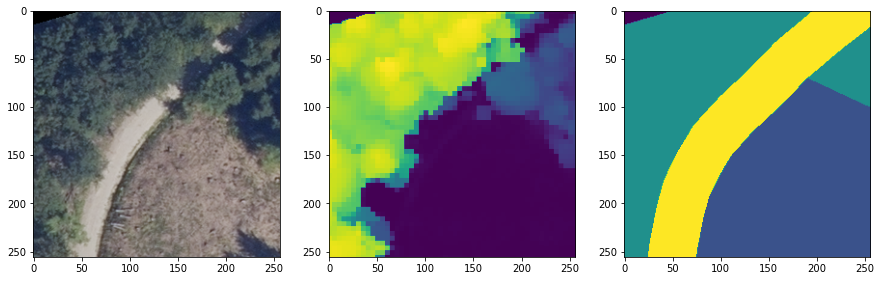

In [6]:
X, y = data[51]
dat = X.numpy().transpose((1, 2, 0))
img = data.stds_wien * dat[:,:,:4] + data.means_wien
th = data.stds_dsm * dat[:,:,4:] + data.means_dsm

fig, ax = plt.subplots(1,3, figsize=(15,9))
ax[0].imshow(img[:,:,:3].astype(np.uint8))
ax[1].imshow(th)
ax[2].imshow(y.numpy())

In [7]:
# split data

In [8]:
batch_size = 8
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed = 13

# Creating data indices for training and validation splits:
dataset_size = 91000
#dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

72800
9100
9100


In [9]:
# Creating PT data samplers and loaders:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(val_indices)
test_sampler = sampler.SubsetRandomSampler(test_indices)

train_dl = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)#, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4)#, pin_memory=True)
test_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=4)#, pin_memory=True)

In [10]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([8, 5, 256, 256]), torch.Size([8, 256, 256]))

In [11]:
## FCDenseNet

In [12]:
import torch
import torch.nn as nn


class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
        self.add_module('conv', nn.Conv2d(in_channels, growth_rate, kernel_size=3,
                                          stride=1, padding=1, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super().forward(x)


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])

    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x


class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels, in_channels,
                                          kernel_size=1, stride=1,
                                          padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))

    def forward(self, x):
        return super().forward(x)


class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=3, stride=2, padding=0, bias=True)

    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out


class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super().__init__()
        self.add_module('bottleneck', DenseBlock(
            in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super().forward(x)


def center_crop(layer, max_height, max_width):
    _, _, h, w = layer.size()
    xy1 = (w - max_width) // 2
    xy2 = (h - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]


In [13]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck',Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        ## Softmax ##

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)

        out = self.bottleneck(out)
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)

        out = self.finalConv(out)
        out = self.softmax(out)
        return out


def FCDenseNet57(in_channels, n_classes):
    return FCDenseNet(
        in_channels=in_channels, down_blocks=(4, 4, 4, 4, 4),
        up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4,
        growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet67(in_channels, n_classes):
    return FCDenseNet(
        in_channels=in_channels, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet103(in_channels, n_classes):
    return FCDenseNet(
        in_channels=in_channels, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

DSET_MEAN = data.means_wien
DSET_STD = data.stds_wien

def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    #mean = np.array(DSET_MEAN)
    #std = np.array(DSET_STD)
    inp = data.stds_wien * inp + data.means_wien
    return inp[:,:,:3]

def view_image(tensor):
    inp = decode_image(tensor)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [15]:
import os
import sys
import math
import string
import random
import shutil

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.functional as F

#from . import imgs as img_utils

RESULTS_PATH = 'results/'
WEIGHTS_PATH = 'weights/'


def save_weights(model, epoch, loss, err):
    weights_fname = 'weights_dsm-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save({
            'startEpoch': epoch,
            'loss':loss,
            'error': err,
            'state_dict': model.state_dict()
        }, weights_fpath)
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'latest_dsm.th')

def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    weights = torch.load(fpath)
    startEpoch = weights['startEpoch']
    model.load_state_dict(weights['state_dict'])
    print("loaded weights (lastEpoch {}, loss {}, error {})"
          .format(startEpoch-1, weights['loss'], weights['error']))
    return startEpoch

def get_predictions(output_batch):
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = np.true_divide(incorrect,n_pixels)
    return err

def train(model, trn_loader, optimizer, criterion, epoch):
    model.train()
    trn_loss = 0
    trn_error = 0
    for idx, data in enumerate(trn_loader):
        inputs = Variable(data[0].cuda())
        targets = Variable(data[1].cuda())

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        #trn_loss += loss.data[0]
        trn_loss += loss.data.item()
        pred = get_predictions(output)
        trn_error += error(pred, targets.data.cpu())
        
        if idx % 100 == 0:
            print('Current step: {}  Loss: {}  Acc: {}'.format(idx, loss.data.item(), error(pred, targets.data.cpu())))

    trn_loss /= len(trn_loader)
    trn_error /= len(trn_loader)
    return trn_loss, trn_error

def test(model, test_loader, criterion, epoch=1):
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        data = Variable(data.cuda())
        target = Variable(target.cuda())
        
        with torch.no_grad():
            output = model(data)
            test_loss += criterion(output, target).data.item()
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader)
    test_error /= len(test_loader)
    return test_loss, test_error

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight)
        m.bias.data.zero_()

def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    predictions = []
    model.eval()
    for input, target in input_loader:
        data = Variable(input.cuda())
        label = Variable(target.cuda())
        
        with torch.no_grad():
            output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions

def view_sample_predictions(model, loader, n):
    inputs, targets = next(iter(loader))
    data = Variable(inputs.cuda())
    label = Variable(targets.cuda())
    with torch.no_grad():
        output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(min(n, batch_size)):
        #img_utils.view_image(inputs[i])
        #img_utils.view_annotated(targets[i])
        #img_utils.view_annotated(pred[i])
        view_image(inputs[i])
        view_annotated(targets[i])
        view_annotated(pred[i])


In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#from models import tiramisu
#from datasets import camvid
#from datasets import joint_transforms
#import utils.imgs
#import utils.training as train_utils

In [17]:
'''
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])
'''

'\nprint("Train: %d" %len(train_loader.dataset.imgs))\nprint("Val: %d" %len(val_loader.dataset.imgs))\nprint("Test: %d" %len(test_loader.dataset.imgs))\nprint("Classes: %d" % len(train_loader.dataset.classes))\n\ninputs, targets = next(iter(train_loader))\nprint("Inputs: ", inputs.size())\nprint("Targets: ", targets.size())\n\nutils.imgs.view_image(inputs[0])\nutils.imgs.view_annotated(targets[0])\n'

In [18]:
# train

In [19]:
LR = 1e-3
LR_DECAY = 0.990
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 10
torch.cuda.manual_seed(0)

In [20]:
model = FCDenseNet57(in_channels=5, n_classes=5).cuda()

path_weights = WEIGHTS_PATH+'latest_dsm.th'
if os.path.isfile(path_weights):
    try:
        load_weights(model, WEIGHTS_PATH+'latest_dsm.th')
        print("weights loaded")
    except:
        model.apply(weights_init)
        print("no weights found")
else:
    model.apply(weights_init)
    print("no weights found")
    
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=class_weight.cuda()).cuda()

loading weights 'weights/latest_dsm.th'
loaded weights (lastEpoch 7, loss 1.428403327997728, error 0.28019952187429203)
weights loaded


In [21]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train(model, train_dl, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss, val_err = test(model, valid_dl, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Current step: 0  Loss: 3.096193552017212  Acc: 0.8433017730712891
Current step: 100  Loss: 6.1896820068359375  Acc: 0.6856212615966797
Current step: 200  Loss: 2.552342176437378  Acc: 0.2928581237792969
Current step: 300  Loss: 5.102053165435791  Acc: 0.57098388671875
Current step: 400  Loss: 1.835680365562439  Acc: 0.5159130096435547
Current step: 500  Loss: 2.281916379928589  Acc: 0.6486625671386719
Current step: 600  Loss: 1.6919666528701782  Acc: 0.6122379302978516
Current step: 700  Loss: 2.146836519241333  Acc: 0.44518280029296875
Current step: 800  Loss: 1.3985992670059204  Acc: 0.48177528381347656
Current step: 900  Loss: 1.8889474868774414  Acc: 0.5012302398681641
Current step: 1000  Loss: 1.0853883028030396  Acc: 0.6268062591552734
Current step: 1100  Loss: 1.0456793308258057  Acc: 0.46582603454589844
Current step: 1200  Loss: 0.6858870387077332  Acc: 0.4551887512207031
Current step: 1300  Loss: 0.9733428359031677  Acc: 0.43527793884277344
Current step: 1400  Loss: 1.64212250

Current step: 2500  Loss: 0.7270084023475647  Acc: 0.1453685760498047
Current step: 2600  Loss: 0.6783336997032166  Acc: 0.36174774169921875
Current step: 2700  Loss: 1.3217806816101074  Acc: 0.4786109924316406
Current step: 2800  Loss: 0.17550522089004517  Acc: 0.11849021911621094
Current step: 2900  Loss: 0.9939361810684204  Acc: 0.27797698974609375
Current step: 3000  Loss: 0.7446601986885071  Acc: 0.1930408477783203
Current step: 3100  Loss: 0.5971057415008545  Acc: 0.5023517608642578
Current step: 3200  Loss: 0.5385021567344666  Acc: 0.08479118347167969
Current step: 3300  Loss: 0.7244568467140198  Acc: 0.1900177001953125
Current step: 3400  Loss: 1.277204990386963  Acc: 0.36038970947265625
Current step: 3500  Loss: 0.41613760590553284  Acc: 0.1788787841796875
Current step: 3600  Loss: 0.9104830026626587  Acc: 0.4785747528076172
Current step: 3700  Loss: 0.872534990310669  Acc: 0.4350395202636719
Current step: 3800  Loss: 0.39989495277404785  Acc: 0.276031494140625
Current step: 3

Current step: 5000  Loss: 0.977642834186554  Acc: 0.22253799438476562
Current step: 5100  Loss: 0.8994373083114624  Acc: 0.3347339630126953
Current step: 5200  Loss: 0.45475518703460693  Acc: 0.1497211456298828
Current step: 5300  Loss: 0.81966233253479  Acc: 0.25702667236328125
Current step: 5400  Loss: 0.6158275008201599  Acc: 0.1968517303466797
Current step: 5500  Loss: 2.0924580097198486  Acc: 0.4901275634765625
Current step: 5600  Loss: 0.8225408792495728  Acc: 0.2893638610839844
Current step: 5700  Loss: 0.7486644983291626  Acc: 0.34702491760253906
Current step: 5800  Loss: 0.5233439803123474  Acc: 0.19169235229492188
Current step: 5900  Loss: 0.8368249535560608  Acc: 0.2453289031982422
Current step: 6000  Loss: 0.9324029088020325  Acc: 0.3921546936035156
Current step: 6100  Loss: 0.5430539846420288  Acc: 0.12182807922363281
Current step: 6200  Loss: 1.1942452192306519  Acc: 0.396209716796875
Current step: 6300  Loss: 1.1206063032150269  Acc: 0.4480133056640625
Current step: 6400

Current step: 7500  Loss: 0.967294454574585  Acc: 0.2724781036376953
Current step: 7600  Loss: 0.5357265472412109  Acc: 0.24189186096191406
Current step: 7700  Loss: 0.7821892499923706  Acc: 0.4060688018798828
Current step: 7800  Loss: 0.9817257523536682  Acc: 0.3050670623779297
Current step: 7900  Loss: 0.45105215907096863  Acc: 0.2959175109863281
Current step: 8000  Loss: 1.194994568824768  Acc: 0.2687702178955078
Current step: 8100  Loss: 0.8311639428138733  Acc: 0.17999267578125
Current step: 8200  Loss: 0.81402587890625  Acc: 0.1964397430419922
Current step: 8300  Loss: 0.7436931133270264  Acc: 0.40451622009277344
Current step: 8400  Loss: 0.9552546739578247  Acc: 0.33202552795410156
Current step: 8500  Loss: 1.0162487030029297  Acc: 0.44710350036621094
Current step: 8600  Loss: 0.7072221636772156  Acc: 0.23379898071289062
Current step: 8700  Loss: 0.7405610084533691  Acc: 0.4484119415283203
Current step: 8800  Loss: 0.5854593515396118  Acc: 0.5193309783935547
Current step: 8900  

Current step: 700  Loss: 0.573168933391571  Acc: 0.1297016143798828
Current step: 800  Loss: 0.6365160942077637  Acc: 0.09810447692871094
Current step: 900  Loss: 0.9543562531471252  Acc: 0.3179492950439453
Current step: 1000  Loss: 0.6707336902618408  Acc: 0.29178428649902344
Current step: 1100  Loss: 0.7300390005111694  Acc: 0.21801376342773438
Current step: 1200  Loss: 0.46567708253860474  Acc: 0.1364612579345703
Current step: 1300  Loss: 0.4786868095397949  Acc: 0.28397369384765625
Current step: 1400  Loss: 0.3718697428703308  Acc: 0.3057708740234375
Current step: 1500  Loss: 0.8526185750961304  Acc: 0.23569297790527344
Current step: 1600  Loss: 0.954054594039917  Acc: 0.28906822204589844
Current step: 1700  Loss: 0.6649271845817566  Acc: 0.22900009155273438
Current step: 1800  Loss: 0.5893348455429077  Acc: 0.3361701965332031
Current step: 1900  Loss: 0.9597097039222717  Acc: 0.4045562744140625
Current step: 2000  Loss: 0.8684830665588379  Acc: 0.3404197692871094
Current step: 210

Current step: 3200  Loss: 0.4575357437133789  Acc: 0.2598762512207031
Current step: 3300  Loss: 0.7932778000831604  Acc: 0.32274818420410156
Current step: 3400  Loss: 0.48337873816490173  Acc: 0.19942855834960938
Current step: 3500  Loss: 0.9090458750724792  Acc: 0.3246021270751953
Current step: 3600  Loss: 0.7812662720680237  Acc: 0.3231678009033203
Current step: 3700  Loss: 0.8318763375282288  Acc: 0.25654029846191406
Current step: 3800  Loss: 1.15743088722229  Acc: 0.36047935485839844
Current step: 3900  Loss: 0.7907454371452332  Acc: 0.26899147033691406
Current step: 4000  Loss: 0.4678491950035095  Acc: 0.21207237243652344
Current step: 4100  Loss: 0.33213046193122864  Acc: 0.2332611083984375
Current step: 4200  Loss: 0.675186038017273  Acc: 0.32381248474121094
Current step: 4300  Loss: 1.1432234048843384  Acc: 0.21979141235351562
Current step: 4400  Loss: 1.1171239614486694  Acc: 0.2384796142578125
Current step: 4500  Loss: 0.5809224247932434  Acc: 0.1435871124267578
Current step:

Current step: 5700  Loss: 0.698677122592926  Acc: 0.164581298828125
Current step: 5800  Loss: 0.7686677575111389  Acc: 0.2799949645996094
Current step: 5900  Loss: 0.6737490892410278  Acc: 0.23366737365722656
Current step: 6000  Loss: 0.7864245176315308  Acc: 0.24302101135253906
Current step: 6100  Loss: 1.0088307857513428  Acc: 0.3870105743408203
Current step: 6200  Loss: 1.0222737789154053  Acc: 0.44565773010253906
Current step: 6300  Loss: 0.999930739402771  Acc: 0.28516387939453125
Current step: 6400  Loss: 0.5025427937507629  Acc: 0.12824630737304688
Current step: 6500  Loss: 1.1759332418441772  Acc: 0.18022918701171875
Current step: 6600  Loss: 0.8377062678337097  Acc: 0.197784423828125
Current step: 6700  Loss: 0.6836515069007874  Acc: 0.1538543701171875
Current step: 6800  Loss: 0.5775614976882935  Acc: 0.3874950408935547
Current step: 6900  Loss: 0.5615056157112122  Acc: 0.4202690124511719
Current step: 7000  Loss: 0.5897016525268555  Acc: 0.13765525817871094
Current step: 710

KeyboardInterrupt: 

In [21]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train(model, train_dl, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss, val_err = test(model, valid_dl, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Current step: 0  Loss: 0.37442871928215027  Acc: 0.10821723937988281
Current step: 100  Loss: 1.2033746242523193  Acc: 0.32158851623535156
Current step: 200  Loss: 0.5063012838363647  Acc: 0.11806106567382812
Current step: 300  Loss: 0.640651524066925  Acc: 0.1967487335205078
Current step: 400  Loss: 1.0801520347595215  Acc: 0.2011585235595703
Current step: 500  Loss: 0.5392746925354004  Acc: 0.19069862365722656
Current step: 600  Loss: 1.1583404541015625  Acc: 0.2686042785644531
Current step: 700  Loss: 1.260469913482666  Acc: 0.36095619201660156
Current step: 800  Loss: 0.7510531544685364  Acc: 0.39327239990234375
Current step: 900  Loss: 0.6803156733512878  Acc: 0.16602516174316406
Current step: 1000  Loss: 0.7063742280006409  Acc: 0.32858848571777344
Current step: 1100  Loss: 0.5672851800918579  Acc: 0.16481971740722656
Current step: 1200  Loss: 0.8608613014221191  Acc: 0.2163524627685547
Current step: 1300  Loss: 1.310792088508606  Acc: 0.6098976135253906
Current step: 1400  Loss:

Current step: 2400  Loss: 0.6341550350189209  Acc: 0.1848163604736328
Current step: 2500  Loss: 0.7375324368476868  Acc: 0.38095855712890625
Current step: 2600  Loss: 0.8469427227973938  Acc: 0.3493671417236328
Current step: 2700  Loss: 0.41906407475471497  Acc: 0.2059783935546875
Current step: 2800  Loss: 0.479350209236145  Acc: 0.2814502716064453
Current step: 2900  Loss: 0.5842010974884033  Acc: 0.18516921997070312
Current step: 3000  Loss: 0.8311872482299805  Acc: 0.318603515625
Current step: 3100  Loss: 0.9016739726066589  Acc: 0.2882957458496094
Current step: 3200  Loss: 0.7193347215652466  Acc: 0.13820266723632812
Current step: 3300  Loss: 0.7633922100067139  Acc: 0.2855815887451172
Current step: 3400  Loss: 0.5231801271438599  Acc: 0.30452919006347656
Current step: 3500  Loss: 0.585883378982544  Acc: 0.11554527282714844
Current step: 3600  Loss: 0.7773693203926086  Acc: 0.30367469787597656
Current step: 3700  Loss: 0.8778092861175537  Acc: 0.24195480346679688
Current step: 3800

Current step: 4800  Loss: 1.2046557664871216  Acc: 0.3141326904296875
Current step: 4900  Loss: 0.9765450358390808  Acc: 0.3087291717529297
Current step: 5000  Loss: 0.6223939657211304  Acc: 0.24827957153320312
Current step: 5100  Loss: 0.46059712767601013  Acc: 0.16686248779296875
Current step: 5200  Loss: 0.7693328857421875  Acc: 0.2746734619140625
Current step: 5300  Loss: 0.307697594165802  Acc: 0.2549285888671875
Current step: 5400  Loss: 0.7043181657791138  Acc: 0.21827316284179688
Current step: 5500  Loss: 0.32779839634895325  Acc: 0.2818603515625
Current step: 5600  Loss: 1.0215104818344116  Acc: 0.31168365478515625
Current step: 5700  Loss: 0.48269030451774597  Acc: 0.1298236846923828
Current step: 5800  Loss: 0.7800976634025574  Acc: 0.24901771545410156
Current step: 5900  Loss: 0.4718472361564636  Acc: 0.09673118591308594
Current step: 6000  Loss: 0.3704853951931  Acc: 0.18587493896484375
Current step: 6100  Loss: 0.928705096244812  Acc: 0.2595062255859375
Current step: 6200

Current step: 7200  Loss: 0.8403106927871704  Acc: 0.20529747009277344
Current step: 7300  Loss: 0.31257569789886475  Acc: 0.18467330932617188
Current step: 7400  Loss: 0.44396647810935974  Acc: 0.2300243377685547
Current step: 7500  Loss: 0.5267592668533325  Acc: 0.17252731323242188
Current step: 7600  Loss: 1.4289393424987793  Acc: 0.28408241271972656
Current step: 7700  Loss: 0.9041991829872131  Acc: 0.3061637878417969
Current step: 7800  Loss: 0.2828739881515503  Acc: 0.3448200225830078
Current step: 7900  Loss: 0.5465169548988342  Acc: 0.2124652862548828
Current step: 8000  Loss: 0.6904650330543518  Acc: 0.1800212860107422
Current step: 8100  Loss: 0.4684855043888092  Acc: 0.11294937133789062
Current step: 8200  Loss: 0.6262146830558777  Acc: 0.21281051635742188
Current step: 8300  Loss: 0.21418456733226776  Acc: 0.10652732849121094
Current step: 8400  Loss: 0.7541752457618713  Acc: 0.25994300842285156
Current step: 8500  Loss: 0.42586562037467957  Acc: 0.09576225280761719
Current

Current step: 400  Loss: 1.2202773094177246  Acc: 0.21444320678710938
Current step: 500  Loss: 1.2045117616653442  Acc: 0.1386547088623047
Current step: 600  Loss: 0.6008950471878052  Acc: 0.2191600799560547
Current step: 700  Loss: 0.4620059132575989  Acc: 0.11583328247070312
Current step: 800  Loss: 0.949286699295044  Acc: 0.2534313201904297
Current step: 900  Loss: 0.7057960033416748  Acc: 0.24635696411132812
Current step: 1000  Loss: 0.7828099727630615  Acc: 0.3808746337890625
Current step: 1100  Loss: 0.6805045008659363  Acc: 0.1706409454345703
Current step: 1200  Loss: 0.859157145023346  Acc: 0.4088172912597656
Current step: 1300  Loss: 0.723322331905365  Acc: 0.17451858520507812
Current step: 1400  Loss: 0.5375343561172485  Acc: 0.2759227752685547
Current step: 1500  Loss: 0.4104800522327423  Acc: 0.060733795166015625
Current step: 1600  Loss: 0.39803802967071533  Acc: 0.14577865600585938
Current step: 1700  Loss: 0.5661545991897583  Acc: 0.3795032501220703
Current step: 1800  L

Current step: 2800  Loss: 1.1023746728897095  Acc: 0.2609672546386719
Current step: 2900  Loss: 0.42044973373413086  Acc: 0.07489967346191406
Current step: 3000  Loss: 0.9122856259346008  Acc: 0.38863372802734375
Current step: 3100  Loss: 0.4345642328262329  Acc: 0.5076847076416016
Current step: 3200  Loss: 1.4742270708084106  Acc: 0.33547210693359375
Current step: 3300  Loss: 0.42941978573799133  Acc: 0.13489151000976562
Current step: 3400  Loss: 0.2858031690120697  Acc: 0.13138771057128906
Current step: 3500  Loss: 0.5327908396720886  Acc: 0.1837635040283203
Current step: 3600  Loss: 0.9425926804542542  Acc: 0.2897796630859375
Current step: 3700  Loss: 0.965066134929657  Acc: 0.17949295043945312
Current step: 3800  Loss: 0.5401890873908997  Acc: 0.2295513153076172
Current step: 3900  Loss: 1.0207326412200928  Acc: 0.21819686889648438
Current step: 4000  Loss: 0.7956582307815552  Acc: 0.3178749084472656
Current step: 4100  Loss: 0.6057400703430176  Acc: 0.1892852783203125
Current step

Current step: 5300  Loss: 0.7739183902740479  Acc: 0.17059898376464844
Current step: 5400  Loss: 0.8297275900840759  Acc: 0.31090736389160156
Current step: 5500  Loss: 1.0461833477020264  Acc: 0.4559459686279297
Current step: 5600  Loss: 0.3555203080177307  Acc: 0.09031867980957031
Current step: 5700  Loss: 0.8762810826301575  Acc: 0.3421630859375
Current step: 5800  Loss: 0.4543662667274475  Acc: 0.08764457702636719
Current step: 5900  Loss: 0.48167288303375244  Acc: 0.23027801513671875
Current step: 6000  Loss: 0.35009390115737915  Acc: 0.09922409057617188
Current step: 6100  Loss: 0.7413668036460876  Acc: 0.2261371612548828
Current step: 6200  Loss: 0.7035995125770569  Acc: 0.34113121032714844
Current step: 6300  Loss: 1.0189220905303955  Acc: 0.4648017883300781
Current step: 6400  Loss: 0.5703575015068054  Acc: 0.3123893737792969
Current step: 6500  Loss: 0.35548606514930725  Acc: 0.1460113525390625
Current step: 6600  Loss: 0.7384924292564392  Acc: 0.13346290588378906
Current step

Current step: 7700  Loss: 0.7984811067581177  Acc: 0.25681114196777344
Current step: 7800  Loss: 0.4122669994831085  Acc: 0.2154216766357422
Current step: 7900  Loss: 1.0032418966293335  Acc: 0.324462890625
Current step: 8000  Loss: 0.3640357553958893  Acc: 0.2013683319091797
Current step: 8100  Loss: 0.8348597884178162  Acc: 0.22782135009765625
Current step: 8200  Loss: 0.15636172890663147  Acc: 0.07179069519042969
Current step: 8300  Loss: 0.457278847694397  Acc: 0.16571426391601562
Current step: 8400  Loss: 0.35797053575515747  Acc: 0.12153816223144531
Current step: 8500  Loss: 0.36032161116600037  Acc: 0.19528770446777344
Current step: 8600  Loss: 0.4253010153770447  Acc: 0.15081024169921875
Current step: 8700  Loss: 0.4762282371520996  Acc: 0.1426239013671875
Current step: 8800  Loss: 0.3190075755119324  Acc: 0.2229328155517578
Current step: 8900  Loss: 0.3526899218559265  Acc: 0.19369125366210938
Current step: 9000  Loss: 0.7670027017593384  Acc: 0.1479511260986328
Epoch 9
Train 

In [ ]:
### Checkpoint ###    
save_weights(model, epoch, val_loss, val_err)

In [ ]:
# test

In [24]:
test(model, test_dl, criterion, epoch=1)  

(0.5788979210705875, tensor(0.1802, dtype=torch.float64))

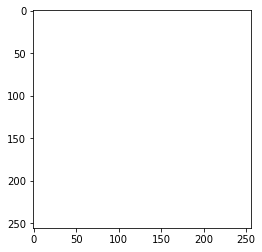

NameError: name 'label_colours' is not defined

In [28]:
view_sample_predictions(model, test_dl, n=1)